In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score

# from transformers import BertTokenizer, BertConfig
# from transformers import BertForTokenClassification, AdamW

from transformers import RobertaConfig, RobertaModel
from transformers import RobertaTokenizer, RobertaForTokenClassification, AutoTokenizer, AdamW


2023-08-04 09:56:20.502187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 09:56:21.024339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

# **Preprocessing data**

In [3]:
# Reading data
import json


#open the file, and format correctly
f =open('all.jsonl', 'r')
json_object = json.dumps(f.readlines(), indent=4)
f.close()

#save better format into file
p = open('sample.txt', 'w')
for i in json_object:
    p.write(i)
p.close()

#open new file, and save each 
j = open('sample.txt', 'r')
text = json.loads(j.read())
j.close()

#compile all json dicts into a list
info = []
for i in text:
    info.append(json.loads(str(i)))
    

In [4]:
# To use the BERT, you must use the BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")


In [5]:
def degreekify(char):
    #char will be a character
    greek = {'α': '[alpha]', 'β':'[beta]', 'γ': '[gamma]', 'δ':'[delta]', 'ε': '[epsilon]', 'ζ':'[zeta]', 'η': '[eta]',
            'θ':'[theta]', 'ι': '[iota]', 'κ':'[kappa]', 'λ':'[lambda]', 'μ': '[mu]', 'ν':'[nu]', 'ξ':'[xi]', 'ο':'[omicron]', 'π':'[pi]', 'ρ':'[rho]',
            'σ': '[sigma]', 'τ': '[tau]', 'υ':'[upsilon]', 'φ':'[phi]', 'χ':'[chi]', 'ψ':'[psi]', 'ω':'[omega]' }
    if char in greek:
        return greek[char]
    else:
        return char

In [6]:
def pre_process(text, annotations):
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    text_dict = []
    
    for i in range(len(text)):
        text_dict.append(degreekify(text[i]))
    
    
    
    ann_indices = []
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    
    
    
    if len(annotations)==0:
        ann_indices.append([[0, len(text)],0])
    else:
        ann_indices.append([[0, annotations[0]['start_offset']], 0])
        for i in range(len(annotations)-1):
            ann_indices.append([[annotations[i]['start_offset'], annotations[i]['end_offset']], data_tags.index(annotations[i]['label'])])
            ann_indices.append([[annotations[i]['end_offset'], annotations[i+1]['start_offset']], 0])
            
        ann_indices.append([[annotations[-1]['start_offset'], annotations[-1]['end_offset']], data_tags.index(annotations[-1]['label'])])
        ann_indices.append([[annotations[-1]['end_offset'], len(text)], 0])
         
    
    labels = []
    sentences = []
    for a in ann_indices:
        
        if a[0][1]-a[0][0] !=0:
            together = ''
            for i in range(a[0][0], a[0][1]):
                together += text_dict[i]
                
            toke = together.split()
            sentences.extend(toke)
            t = len(toke)
            if t != 0:
                temp = [data_tags[a[1]+1]] * t
                if a[1] != 0:
                    temp[0] = data_tags[a[1]]
                labels.extend(temp)
 
    return labels, sentences

In [7]:
def reduce(sent, label, slist, llist):
    lens = len(sent)
    if lens < 256:
        slist.append(sent)
        llist.append(label)
    else:
        t = lens//2
        return reduce(sent[:t], label[:t], slist, llist), reduce(sent[t:], label[t:], slist, llist)
    


In [8]:
#create labels
data_tags = ['ahhhhhhhhhhhhhhhhhhhh','0','Metal', 'M-cont', 'Element', 'E-cont', 'Acid', 'A-cont', 'Yield' , 'Y-cont', 'Separation Method' , 'S-cont', 'Resin', 'R-cont', 'Method of Analysis', 'T-cont', 'pH', 'P-cont', 'Chemical Compound', 'H-cont', 'Organic solvent', 'O-cont', 'Element Group', 'G-cont', 'Inorganic Solvent', 'I-cont', 'Flowrate', 'F-cont', 'Acid Concentration', 'C-cont', 'Reagent', 'X-cont']

sent_test, label_test= [], []
sentences, labels = [], []

for i in range(len(info)):
    l, s = pre_process(info[i]['text'], info[i]['entities'])
  
    if i % 5 == 0:
        reduce(s,l,sent_test, label_test)
    else:
        reduce(s,l,sentences, labels)


data_tags = data_tags[1:]


In [10]:

# Determine the list of tags
tag_values = data_tags
print(tag_values)

tag_values.append("PAD")
print(tag_values)

tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)
     

['0', 'Metal', 'M-cont', 'Element', 'E-cont', 'Acid', 'A-cont', 'Yield', 'Y-cont', 'Separation Method', 'S-cont', 'Resin', 'R-cont', 'Method of Analysis', 'T-cont', 'pH', 'P-cont', 'Chemical Compound', 'H-cont', 'Organic solvent', 'O-cont', 'Element Group', 'G-cont', 'Inorganic Solvent', 'I-cont', 'Flowrate', 'F-cont', 'Acid Concentration', 'C-cont', 'Reagent', 'X-cont']
['0', 'Metal', 'M-cont', 'Element', 'E-cont', 'Acid', 'A-cont', 'Yield', 'Y-cont', 'Separation Method', 'S-cont', 'Resin', 'R-cont', 'Method of Analysis', 'T-cont', 'pH', 'P-cont', 'Chemical Compound', 'H-cont', 'Organic solvent', 'O-cont', 'Element Group', 'G-cont', 'Inorganic Solvent', 'I-cont', 'Flowrate', 'F-cont', 'Acid Concentration', 'C-cont', 'Reagent', 'X-cont', 'PAD']
{'0': 0, 'Metal': 1, 'M-cont': 2, 'Element': 3, 'E-cont': 4, 'Acid': 5, 'A-cont': 6, 'Yield': 7, 'Y-cont': 8, 'Separation Method': 9, 'S-cont': 10, 'Resin': 11, 'R-cont': 12, 'Method of Analysis': 13, 'T-cont': 14, 'pH': 15, 'P-cont': 16, 'Chemi

In [11]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [12]:
tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [13]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 256 # 64 or 128 or ...
bs = 6 # batch size


In [14]:
# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
     

In [15]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [16]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

print(train_sampler)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


# **Build model**

In [17]:
# Load RoBERTa Model
from transformers import AutoTokenizer, AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(
    "roberta-base",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
    
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

In [18]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [19]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= 4e-5, # learning-rate default is 3e-5
    eps=1e-8 # adam-epsilon default is 1e-8
)


/home/ecasey/anaconda3/envs/torch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
epochs = 100

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1000,
    num_training_steps=total_steps
)

# **Training**

In [21]:
def acc(print_labels, special):
    accuracy_list = []
    max_a = 0
    index_a = 1000000
    
    for i in range(len(sentences)):
       
        
        s, l = tokenize_and_preserve_labels(sentences[i], labels[i])
    
        
        temp1 = []
     
        for j in range(len(s)):
            t = tokenizer.convert_tokens_to_ids(s[j])
            temp1.append(t)
            
        tokenized_sentence = temp1
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-1]
        a = accuracy_score(new_labels, labels[i])
        if a  >= max_a and i !=4:
            max_a = a
            index_a = i
          
        accuracy_list.append(a)
        if print_labels == True:
            print("___________________"+ str(i)+"___________________")
            print("\nPredict labels: ",new_labels)
            print("Actual labels: ",labels[i])
            print()
            print()
            if special == i:
                for j in range(len(sentences[i])):
                    print(sentences[i][j], new_labels[j])
    print(index_a, max_a)
    return statistics.mean(accuracy_list)
 

In [22]:
def acc_test(print_labels, special):
    accuracy_list = []
    max_a = 0
    index_a = 1000000
    
    for i in range(len(sent_test)):
       
        
        s, label_test[i] = tokenize_and_preserve_labels(sent_test[i], label_test[i])
    
        
        temp1 = []
     
        for j in range(len(s)):
            t = tokenizer.convert_tokens_to_ids(s[j])
            temp1.append(t)
            
        tokenized_sentence = temp1
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-1]
        a = accuracy_score(new_labels, label_test[i])
        if a  >= max_a and i !=4:
            max_a = a
            index_a = i
          
        accuracy_list.append(a)
        if print_labels == True:
            print("___________________"+ str(i)+"___________________")
            print("\nPredict labels: ",new_labels)
            print("Actual labels: ",label_test[i])
            print()
            print()
            if special == i:
                for j in range(len(sent_test[i])):
                    print(sent_test[i][j], new_labels[j])
    print(index_a, max_a)
    return statistics.mean(accuracy_list)
        


In [23]:
from torch import nn
from transformers import Trainer
w = [.99, 0.0008, .0008, .99,.99, .0319, .0319, .0239, .0239, .0736, .0736, .0135, .0135, .0526, .0526, .0083, .0083, .0463, .0436, .0324, .0324, .0324, .014, .014, .0386, .0386, .0004, .0004, .0293, .0293, .0421, .0421]
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(w))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [24]:
## Store the average loss after each epoch so we can plot them.
import copy
loss_values, validation_loss_values = [], []

test_acc = []

max_test = 10

for e in trange(epochs, desc="Epoch"):
    
    
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    a = eval_loss
    
    test_acc.append(a)
    if a <= max_test:
        max_test = a
    elif  max_test * 1.05 >= a and max_test < a:
        torch.save(model, "check.ck")
torch.save(model, "end.ck")       

Epoch:   1%|▉                                                                                        | 1/100 [00:06<10:15,  6.21s/it]


Average train loss: 3.435225119957557

Validation loss: 2.786343296368917
Validation Accuracy: 0.6882548108825481



Epoch:   2%|█▊                                                                                       | 2/100 [00:11<09:40,  5.93s/it]


Average train loss: 1.527191902582462

Validation loss: 1.0507776240507762
Validation Accuracy: 0.7737226277372263



Epoch:   3%|██▋                                                                                      | 3/100 [00:17<09:26,  5.84s/it]


Average train loss: 0.8727273390843318

Validation loss: 0.7626044452190399
Validation Accuracy: 0.7751824817518248



Epoch:   4%|███▌                                                                                     | 4/100 [00:23<09:17,  5.80s/it]


Average train loss: 0.6430084195274574

Validation loss: 0.5679274449745814
Validation Accuracy: 0.8509621765096218



Epoch:   5%|████▍                                                                                    | 5/100 [00:29<09:09,  5.79s/it]


Average train loss: 0.4981592311882056

Validation loss: 0.45937176545461017
Validation Accuracy: 0.8708692767086927



Epoch:   6%|█████▎                                                                                   | 6/100 [00:34<09:03,  5.78s/it]


Average train loss: 0.4011635179989613

Validation loss: 0.38784631093343097
Validation Accuracy: 0.8838752488387525



Epoch:   7%|██████▏                                                                                  | 7/100 [00:40<08:57,  5.78s/it]


Average train loss: 0.3429358878101294

Validation loss: 0.340031494696935
Validation Accuracy: 0.8952886529528865



Epoch:   8%|███████                                                                                  | 8/100 [00:46<08:51,  5.78s/it]


Average train loss: 0.2800534454962382

Validation loss: 0.33865898723403615
Validation Accuracy: 0.8911745189117452



Epoch:   9%|████████                                                                                 | 9/100 [00:52<08:46,  5.78s/it]


Average train loss: 0.23663416118002856

Validation loss: 0.31319303810596466
Validation Accuracy: 0.9005972130059722



Epoch:  10%|████████▊                                                                               | 10/100 [00:58<08:41,  5.79s/it]


Average train loss: 0.20991796341079932

Validation loss: 0.3073475907246272
Validation Accuracy: 0.9092236230922363



Epoch:  11%|█████████▋                                                                              | 11/100 [01:03<08:35,  5.79s/it]


Average train loss: 0.17612672367921242

Validation loss: 0.3239457408587138
Validation Accuracy: 0.9150630391506304


Average train loss: 0.15675891240915427

Validation loss: 0.3115159956117471
Validation Accuracy: 0.9202388852023888



Epoch:  12%|██████████▌                                                                             | 12/100 [01:14<10:35,  7.22s/it]


Average train loss: 0.13528744933696893

Validation loss: 0.32105006898442906
Validation Accuracy: 0.9169210351692103



Epoch:  14%|████████████▎                                                                           | 14/100 [01:30<10:42,  7.47s/it]


Average train loss: 0.11281268101615402

Validation loss: 0.3263068211575349
Validation Accuracy: 0.9218314532183145


Average train loss: 0.09773549537819165

Validation loss: 0.3158576140801112
Validation Accuracy: 0.9191771731917717



Epoch:  16%|██████████████                                                                          | 16/100 [01:46<10:39,  7.61s/it]


Average train loss: 0.0805293762196715

Validation loss: 0.32277700304985046
Validation Accuracy: 0.9182481751824818



Epoch:  17%|██████████████▉                                                                         | 17/100 [01:52<09:46,  7.07s/it]


Average train loss: 0.07482186704874039

Validation loss: 0.28829099672536057
Validation Accuracy: 0.9267418712674187



Epoch:  18%|███████████████▊                                                                        | 18/100 [01:58<09:08,  6.69s/it]


Average train loss: 0.06797003331415069

Validation loss: 0.33003756279746693
Validation Accuracy: 0.9183808891838089



Epoch:  19%|████████████████▋                                                                       | 19/100 [02:04<08:40,  6.43s/it]


Average train loss: 0.06029618133862431

Validation loss: 0.33854032183686894
Validation Accuracy: 0.9081619110816191



Epoch:  20%|█████████████████▌                                                                      | 20/100 [02:10<08:19,  6.25s/it]


Average train loss: 0.053279602291205756

Validation loss: 0.3107631281018257
Validation Accuracy: 0.9287325812873258



Epoch:  21%|██████████████████▍                                                                     | 21/100 [02:15<08:03,  6.12s/it]


Average train loss: 0.049181588450804926

Validation loss: 0.3487992969652017
Validation Accuracy: 0.9205043132050431



Epoch:  22%|███████████████████▎                                                                    | 22/100 [02:21<07:50,  6.03s/it]


Average train loss: 0.03947886511853609

Validation loss: 0.3503875533739726
Validation Accuracy: 0.9287325812873258



Epoch:  23%|████████████████████▏                                                                   | 23/100 [02:27<07:40,  5.97s/it]


Average train loss: 0.03793169966397377

Validation loss: 0.36751845354835194
Validation Accuracy: 0.9278035832780358



Epoch:  24%|█████████████████████                                                                   | 24/100 [02:33<07:30,  5.93s/it]


Average train loss: 0.030828108330472156

Validation loss: 0.38276448224981624
Validation Accuracy: 0.9224950232249503



Epoch:  25%|██████████████████████                                                                  | 25/100 [02:39<07:23,  5.91s/it]


Average train loss: 0.034848046014443614

Validation loss: 0.37275950486461323
Validation Accuracy: 0.9258128732581288



Epoch:  26%|██████████████████████▉                                                                 | 26/100 [02:45<07:15,  5.89s/it]


Average train loss: 0.02429008623585105

Validation loss: 0.3758857709666093
Validation Accuracy: 0.9292634372926344



Epoch:  27%|███████████████████████▊                                                                | 27/100 [02:51<07:08,  5.88s/it]


Average train loss: 0.02356998059594144

Validation loss: 0.3934945650398731
Validation Accuracy: 0.9271400132714002



Epoch:  28%|████████████████████████▋                                                               | 28/100 [02:56<07:02,  5.87s/it]


Average train loss: 0.019474054149423655

Validation loss: 0.3449988520393769
Validation Accuracy: 0.935633709356337



Epoch:  29%|█████████████████████████▌                                                              | 29/100 [03:02<06:56,  5.86s/it]


Average train loss: 0.019108692430353794

Validation loss: 0.39098722860217094
Validation Accuracy: 0.9271400132714002



Epoch:  30%|██████████████████████████▍                                                             | 30/100 [03:08<06:49,  5.86s/it]


Average train loss: 0.01576931921030896

Validation loss: 0.41387614111105603
Validation Accuracy: 0.9272727272727272



Epoch:  31%|███████████████████████████▎                                                            | 31/100 [03:14<06:43,  5.85s/it]


Average train loss: 0.013483588050943442

Validation loss: 0.42706895743807155
Validation Accuracy: 0.926078301260783



Epoch:  32%|████████████████████████████▏                                                           | 32/100 [03:20<06:37,  5.85s/it]


Average train loss: 0.012563859985675663

Validation loss: 0.4090716453890006
Validation Accuracy: 0.9312541473125415



Epoch:  33%|█████████████████████████████                                                           | 33/100 [03:26<06:31,  5.85s/it]


Average train loss: 0.01214032357025784

Validation loss: 0.440475861231486
Validation Accuracy: 0.9264764432647644



Epoch:  34%|█████████████████████████████▉                                                          | 34/100 [03:31<06:26,  5.85s/it]


Average train loss: 0.01003494194502799

Validation loss: 0.4128549148639043
Validation Accuracy: 0.9319177173191772



Epoch:  35%|██████████████████████████████▊                                                         | 35/100 [03:37<06:20,  5.85s/it]


Average train loss: 0.011593013840655867

Validation loss: 0.4149746187031269
Validation Accuracy: 0.9259455872594559



Epoch:  36%|███████████████████████████████▋                                                        | 36/100 [03:43<06:14,  5.85s/it]


Average train loss: 0.012165097687662078

Validation loss: 0.4014273174107075
Validation Accuracy: 0.9304578633045786



Epoch:  37%|████████████████████████████████▌                                                       | 37/100 [03:49<06:08,  5.85s/it]


Average train loss: 0.01166588311697034

Validation loss: 0.4259598987797896
Validation Accuracy: 0.9284671532846716



Epoch:  38%|█████████████████████████████████▍                                                      | 38/100 [03:55<06:02,  5.85s/it]


Average train loss: 0.011005224521795753

Validation loss: 0.4351219522456328
Validation Accuracy: 0.9252820172528202



Epoch:  39%|██████████████████████████████████▎                                                     | 39/100 [04:01<05:56,  5.85s/it]


Average train loss: 0.010311934810418349

Validation loss: 0.44071534896890324
Validation Accuracy: 0.927936297279363



Epoch:  40%|███████████████████████████████████▏                                                    | 40/100 [04:07<05:50,  5.85s/it]


Average train loss: 0.00944539701595204

Validation loss: 0.4126091003417969
Validation Accuracy: 0.9214333112143331



Epoch:  41%|████████████████████████████████████                                                    | 41/100 [04:12<05:45,  5.85s/it]


Average train loss: 0.008943618507216273

Validation loss: 0.435432023058335
Validation Accuracy: 0.9285998672859986



Epoch:  42%|████████████████████████████████████▉                                                   | 42/100 [04:18<05:39,  5.85s/it]


Average train loss: 0.00791898334864527

Validation loss: 0.4440544620156288
Validation Accuracy: 0.9283344392833444



Epoch:  43%|█████████████████████████████████████▊                                                  | 43/100 [04:24<05:33,  5.85s/it]


Average train loss: 0.008014245634303033

Validation loss: 0.4273926801979542
Validation Accuracy: 0.9268745852687459



Epoch:  44%|██████████████████████████████████████▋                                                 | 44/100 [04:30<05:27,  5.85s/it]


Average train loss: 0.007762949949280413

Validation loss: 0.43677474930882454
Validation Accuracy: 0.9311214333112143



Epoch:  45%|███████████████████████████████████████▌                                                | 45/100 [04:36<05:21,  5.85s/it]


Average train loss: 0.007629868058407178

Validation loss: 0.4676954187452793
Validation Accuracy: 0.9223623092236231



Epoch:  46%|████████████████████████████████████████▍                                               | 46/100 [04:42<05:15,  5.85s/it]


Average train loss: 0.00674956031770517

Validation loss: 0.46552833418051404
Validation Accuracy: 0.9211678832116789



Epoch:  47%|█████████████████████████████████████████▎                                              | 47/100 [04:47<05:10,  5.85s/it]


Average train loss: 0.006854249990003434

Validation loss: 0.44052357599139214
Validation Accuracy: 0.9274054412740544



Epoch:  48%|██████████████████████████████████████████▏                                             | 48/100 [04:53<05:04,  5.85s/it]


Average train loss: 0.006711568546262032

Validation loss: 0.45434896399577457
Validation Accuracy: 0.9274054412740544



Epoch:  49%|███████████████████████████████████████████                                             | 49/100 [04:59<04:58,  5.85s/it]


Average train loss: 0.006359081098568053

Validation loss: 0.467331192145745
Validation Accuracy: 0.9206370272063703



Epoch:  50%|████████████████████████████████████████████                                            | 50/100 [05:05<04:52,  5.85s/it]


Average train loss: 0.006454950665591661

Validation loss: 0.4576219158867995
Validation Accuracy: 0.927936297279363



Epoch:  51%|████████████████████████████████████████████▉                                           | 51/100 [05:11<04:46,  5.85s/it]


Average train loss: 0.006190309391968185

Validation loss: 0.48225179438789684
Validation Accuracy: 0.9295288652952887



Epoch:  52%|█████████████████████████████████████████████▊                                          | 52/100 [05:17<04:40,  5.85s/it]


Average train loss: 0.006711062481582093

Validation loss: 0.4240543742974599
Validation Accuracy: 0.93271400132714



Epoch:  53%|██████████████████████████████████████████████▋                                         | 53/100 [05:23<04:35,  5.85s/it]


Average train loss: 0.005302676623194622

Validation loss: 0.463721364736557
Validation Accuracy: 0.9311214333112143



Epoch:  54%|███████████████████████████████████████████████▌                                        | 54/100 [05:28<04:29,  5.85s/it]


Average train loss: 0.004941344990724106

Validation loss: 0.4637336730957031
Validation Accuracy: 0.9291307232913072



Epoch:  55%|████████████████████████████████████████████████▍                                       | 55/100 [05:34<04:23,  5.85s/it]


Average train loss: 0.005198170039175938

Validation loss: 0.4842728177706401
Validation Accuracy: 0.9216987392169874



Epoch:  56%|█████████████████████████████████████████████████▎                                      | 56/100 [05:40<04:17,  5.85s/it]


Average train loss: 0.005505393981785836

Validation loss: 0.4635666621228059
Validation Accuracy: 0.9287325812873258



Epoch:  57%|██████████████████████████████████████████████████▏                                     | 57/100 [05:46<04:11,  5.85s/it]


Average train loss: 0.004820229449531046

Validation loss: 0.48748589182893437
Validation Accuracy: 0.9219641672196417



Epoch:  58%|███████████████████████████████████████████████████                                     | 58/100 [05:52<04:05,  5.85s/it]


Average train loss: 0.004738546429087784

Validation loss: 0.5012928334375223
Validation Accuracy: 0.9263437292634373



Epoch:  59%|███████████████████████████████████████████████████▉                                    | 59/100 [05:58<03:59,  5.85s/it]


Average train loss: 0.005178563425803217

Validation loss: 0.47951753064990044
Validation Accuracy: 0.9304578633045786



Epoch:  60%|████████████████████████████████████████████████████▊                                   | 60/100 [06:04<03:54,  5.85s/it]


Average train loss: 0.004882278913870463

Validation loss: 0.492144330094258
Validation Accuracy: 0.9287325812873258



Epoch:  61%|█████████████████████████████████████████████████████▋                                  | 61/100 [06:09<03:48,  5.85s/it]


Average train loss: 0.004859018251758803

Validation loss: 0.4863441027700901
Validation Accuracy: 0.9285998672859986



Epoch:  62%|██████████████████████████████████████████████████████▌                                 | 62/100 [06:15<03:42,  5.85s/it]


Average train loss: 0.00419349608385416

Validation loss: 0.49563730880618095
Validation Accuracy: 0.9311214333112143



Epoch:  63%|███████████████████████████████████████████████████████▍                                | 63/100 [06:21<03:36,  5.85s/it]


Average train loss: 0.004256990718344101

Validation loss: 0.48211490487058956
Validation Accuracy: 0.9297942932979429



Epoch:  64%|████████████████████████████████████████████████████████▎                               | 64/100 [06:27<03:30,  5.85s/it]


Average train loss: 0.004703091727815962

Validation loss: 0.4699658937752247
Validation Accuracy: 0.9324485733244857



Epoch:  65%|█████████████████████████████████████████████████████████▏                              | 65/100 [06:33<03:24,  5.85s/it]


Average train loss: 0.0050030526732511

Validation loss: 0.4761003963649273
Validation Accuracy: 0.9307232913072329



Epoch:  66%|██████████████████████████████████████████████████████████                              | 66/100 [06:39<03:18,  5.85s/it]


Average train loss: 0.0043968991619924335

Validation loss: 0.4888319969177246
Validation Accuracy: 0.9268745852687459



Epoch:  67%|██████████████████████████████████████████████████████████▉                             | 67/100 [06:45<03:13,  5.85s/it]


Average train loss: 0.004613660093897264

Validation loss: 0.46638232966264087
Validation Accuracy: 0.9289980092899801



Epoch:  68%|███████████████████████████████████████████████████████████▊                            | 68/100 [06:50<03:07,  5.85s/it]


Average train loss: 0.004724939203207703

Validation loss: 0.48941494648655254
Validation Accuracy: 0.9274054412740544



Epoch:  69%|████████████████████████████████████████████████████████████▋                           | 69/100 [06:56<03:01,  5.85s/it]


Average train loss: 0.0041077292279134365

Validation loss: 0.5065672794977824
Validation Accuracy: 0.926078301260783



Epoch:  70%|█████████████████████████████████████████████████████████████▌                          | 70/100 [07:02<02:55,  5.85s/it]


Average train loss: 0.0043755858115708595

Validation loss: 0.47633546218276024
Validation Accuracy: 0.9303251493032515



Epoch:  71%|██████████████████████████████████████████████████████████████▍                         | 71/100 [07:08<02:49,  5.85s/it]


Average train loss: 0.004830953479960534

Validation loss: 0.5021449141204357
Validation Accuracy: 0.927936297279363



Epoch:  72%|███████████████████████████████████████████████████████████████▎                        | 72/100 [07:14<02:43,  5.85s/it]


Average train loss: 0.004085400888400797

Validation loss: 0.47688244531552
Validation Accuracy: 0.9250165892501659



Epoch:  73%|████████████████████████████████████████████████████████████████▏                       | 73/100 [07:20<02:38,  5.85s/it]


Average train loss: 0.0043808862414712515

Validation loss: 0.49069226284821826
Validation Accuracy: 0.9285998672859986



Epoch:  74%|█████████████████████████████████████████████████████████████████                       | 74/100 [07:25<02:32,  5.85s/it]


Average train loss: 0.004070824838121412

Validation loss: 0.5017067256073157
Validation Accuracy: 0.9280690112806901



Epoch:  75%|██████████████████████████████████████████████████████████████████                      | 75/100 [07:31<02:26,  5.85s/it]


Average train loss: 0.00385013089936155

Validation loss: 0.48858190203706425
Validation Accuracy: 0.9238221632382216



Epoch:  76%|██████████████████████████████████████████████████████████████████▉                     | 76/100 [07:37<02:20,  5.85s/it]


Average train loss: 0.0037197103118579923

Validation loss: 0.5062588192522526
Validation Accuracy: 0.927007299270073



Epoch:  77%|███████████████████████████████████████████████████████████████████▊                    | 77/100 [07:43<02:14,  5.85s/it]


Average train loss: 0.00354245171169728

Validation loss: 0.5090011519690355
Validation Accuracy: 0.9304578633045786



Epoch:  78%|████████████████████████████████████████████████████████████████████▋                   | 78/100 [07:49<02:08,  5.85s/it]


Average train loss: 0.004323800106738837

Validation loss: 0.5052044925590357
Validation Accuracy: 0.9284671532846716



Epoch:  79%|█████████████████████████████████████████████████████████████████████▌                  | 79/100 [07:55<02:02,  5.85s/it]


Average train loss: 0.003768518172504488

Validation loss: 0.500358177969853
Validation Accuracy: 0.9304578633045786



Epoch:  80%|██████████████████████████████████████████████████████████████████████▍                 | 80/100 [08:01<01:57,  5.85s/it]


Average train loss: 0.00402948453008251

Validation loss: 0.5039896008869013
Validation Accuracy: 0.9317850033178501



Epoch:  81%|███████████████████████████████████████████████████████████████████████▎                | 81/100 [08:06<01:51,  5.85s/it]


Average train loss: 0.003784562558324139

Validation loss: 0.5144861824810505
Validation Accuracy: 0.9311214333112143



Epoch:  82%|████████████████████████████████████████████████████████████████████████▏               | 82/100 [08:12<01:45,  5.85s/it]


Average train loss: 0.00446434796685935

Validation loss: 0.50826999420921
Validation Accuracy: 0.9295288652952887



Epoch:  83%|█████████████████████████████████████████████████████████████████████████               | 83/100 [08:18<01:39,  5.85s/it]


Average train loss: 0.0036555449213875155

Validation loss: 0.5148908545573553
Validation Accuracy: 0.9316522893165229



Epoch:  84%|█████████████████████████████████████████████████████████████████████████▉              | 84/100 [08:24<01:33,  5.85s/it]


Average train loss: 0.0034578662548833215

Validation loss: 0.5162466019392014
Validation Accuracy: 0.9320504313205044



Epoch:  85%|██████████████████████████████████████████████████████████████████████████▊             | 85/100 [08:30<01:27,  5.85s/it]


Average train loss: 0.0038401680922106607

Validation loss: 0.5194739798704783
Validation Accuracy: 0.9311214333112143



Epoch:  86%|███████████████████████████████████████████████████████████████████████████▋            | 86/100 [08:36<01:21,  5.85s/it]


Average train loss: 0.003603049996644796

Validation loss: 0.5108167318006357
Validation Accuracy: 0.9319177173191772



Epoch:  87%|████████████████████████████████████████████████████████████████████████████▌           | 87/100 [08:42<01:16,  5.85s/it]


Average train loss: 0.0033600098486203933

Validation loss: 0.5141254104673862
Validation Accuracy: 0.9313868613138686



Epoch:  88%|█████████████████████████████████████████████████████████████████████████████▍          | 88/100 [08:47<01:10,  5.85s/it]


Average train loss: 0.0036550138351091077

Validation loss: 0.5092643139262995
Validation Accuracy: 0.9321831453218314



Epoch:  89%|██████████████████████████████████████████████████████████████████████████████▎         | 89/100 [08:53<01:04,  5.85s/it]


Average train loss: 0.003260003905010168

Validation loss: 0.5085478785137335
Validation Accuracy: 0.9321831453218314



Epoch:  90%|███████████████████████████████████████████████████████████████████████████████▏        | 90/100 [08:59<00:58,  5.85s/it]


Average train loss: 0.0033620288985940325

Validation loss: 0.5036976772050062
Validation Accuracy: 0.9315195753151958



Epoch:  91%|████████████████████████████████████████████████████████████████████████████████        | 91/100 [09:05<00:52,  5.85s/it]


Average train loss: 0.003219758805174094

Validation loss: 0.5008615255355835
Validation Accuracy: 0.9320504313205044



Epoch:  92%|████████████████████████████████████████████████████████████████████████████████▉       | 92/100 [09:11<00:46,  5.85s/it]


Average train loss: 0.003414937083457167

Validation loss: 0.5069662642975649
Validation Accuracy: 0.9309887193098872



Epoch:  93%|█████████████████████████████████████████████████████████████████████████████████▊      | 93/100 [09:17<00:40,  5.85s/it]


Average train loss: 0.003128329650000803

Validation loss: 0.5126226407786211
Validation Accuracy: 0.9296615792966157



Epoch:  94%|██████████████████████████████████████████████████████████████████████████████████▋     | 94/100 [09:23<00:35,  5.85s/it]


Average train loss: 0.003177893669999321

Validation loss: 0.5123268105089664
Validation Accuracy: 0.9312541473125415



Epoch:  95%|███████████████████████████████████████████████████████████████████████████████████▌    | 95/100 [09:28<00:29,  5.85s/it]


Average train loss: 0.00312867416505469

Validation loss: 0.512345469246308
Validation Accuracy: 0.92992700729927



Epoch:  96%|████████████████████████████████████████████████████████████████████████████████████▍   | 96/100 [09:34<00:23,  5.85s/it]


Average train loss: 0.003197548213462981

Validation loss: 0.5137384496629238
Validation Accuracy: 0.9307232913072329



Epoch:  97%|█████████████████████████████████████████████████████████████████████████████████████▎  | 97/100 [09:40<00:17,  5.85s/it]


Average train loss: 0.0029885858033454637

Validation loss: 0.514536819110314
Validation Accuracy: 0.93085600530856



Epoch:  98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 98/100 [09:46<00:11,  5.85s/it]


Average train loss: 0.0032185621067373385

Validation loss: 0.5141256836553415
Validation Accuracy: 0.9305905773059058



Epoch:  99%|███████████████████████████████████████████████████████████████████████████████████████ | 99/100 [09:52<00:05,  5.85s/it]


Average train loss: 0.0032481409951007944

Validation loss: 0.5138866566121578
Validation Accuracy: 0.9307232913072329



Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:58<00:00,  5.98s/it]


Average train loss: 0.0030743119010507003

Validation loss: 0.5135976436237494
Validation Accuracy: 0.9307232913072329



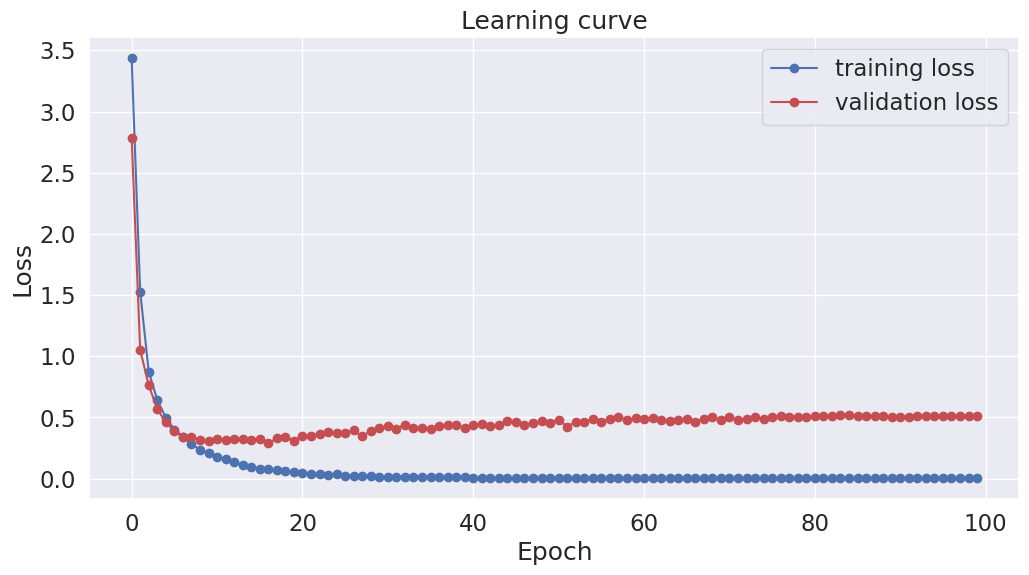

In [25]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Performance on test data

In [28]:
q = len(labels)-1
print(acc(False, q))
acc(True, q)


308 1.0
0.8745905074192653
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


___________________1___________________

Predict labels:  ['Metal', 'Metal', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Ele

___________________16___________________

Predict labels:  ['0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid Concentration', 'Acid Concentration', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________37___________________

Predict labels:  ['Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'Inorganic Solvent', 'Inorganic Solvent', 'Inorganic Solvent', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', '0', 'Acid', 'Acid', 'Acid', 'A-cont', '0', '0', 'Inorganic Solvent', 'Inorganic Solvent', 'I-cont', 'I-cont', 'I-cont', 'I-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-con

___________________58___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', 'Method of Analysis', 'Method of Analysis', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', 'Element', 'Element', '0', '0', '0', '0',

___________________82___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', 'Acid', 'Acid', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'A-cont', 'A-cont', 'A-cont', 'A-cont', 'A-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', 'Chemical Compound', 'Chemical Compound', '0', '0', 'Element', 'E-cont', 'E-cont', 'E-cont', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', 'Acid', '

___________________106___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'T-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'T-con

___________________128___________________

Predict labels:  ['0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid Concentration', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', 'Element', 'Element', '0', 'Element', 'Element', '0', '0', 'Element', 'Element', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid Concentration', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'S-cont', '

___________________151___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Yield', 'Yield', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Yield', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Yield', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

___________________174___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', 'Element', '0', '0', 'Element Group', 'Element Group', 'Element Group', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element Group', 'Element Group', '0', 'Element Group', 'Element Group', 'Element Group', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element Group', 'Element Group', 'Element Group', 

___________________199___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________224___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'S-cont', 'S-cont', '0', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', 'Element', 'Element', '0',

___________________242___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', 'Chemical Compound', 'Chemical Compound', 'H-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Yield', 'Yield', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', 

___________________262___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', 'Element', '0', 'Element', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', 'Element', '0', 'Element', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', 'Organic solvent', 'Organic solvent', 'Organic solvent', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 'Element', 'Element', '0', 'Element', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

___________________279___________________

Predict labels:  ['0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', 'T-cont', '0', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', 'Method of Analysis', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Yield', 'Yield', 'Y-cont', 'Y-cont', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Yield', 'Yield', 'Y-cont', 'Y-cont', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Yield', 'Yield', 'Y-cont', 'Y-cont', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Yield'

___________________295___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Ele

___________________314___________________

Predict labels:  ['Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'

___________________332___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Inorganic Solvent', 'Inorganic Solvent', 'Inorganic Solvent', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', '0', 'Inorganic Solvent', 'Inorganic Solvent', 'Inorganic Solvent', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', '0', 'Inorganic Solvent', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', 'I-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', '0', 

0.8745905074192653

In [29]:

print(acc_test(False, 103))
print(acc_test(True, 103))

37 1.0
0.819613031814845
___________________0___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'A-cont', '0', 'Acid', 'Acid', 'Acid', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', '0', 'Separation Method', 'Separation Method', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', '0', 'Separation Method', 'Separation Method', 'Separation Method', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'A-cont', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', 'A-cont', '0', 'Acid', 'Acid', 'Acid', 'Acid', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Acid', 'Acid', '0', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'Acid', 'A-cont', 'A-c

___________________19___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Chemical Compound', 'Chemical Compound', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', 'Separation Method', 'Separation Method', 'Separation Method', 'Separation Method', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', 'S-cont', '0', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', '0', 

___________________40___________________

Predict labels:  ['0', '0', '0', '0', '0', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Yield', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

___________________63___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', 'Yield', 'Yield', 'Yield', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', 'Yield', 'Y-cont', 'Y-cont', 'Y-cont', 'Y-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', '0', 

___________________81___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', '0', 'Element', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Element', 'Element', 'Element', 'Element', 'Element', 'Element', '0', '0', '0', '0', '0

In [ ]:
model = torch.load("test.ck")
model.eval()

print(acc_test(False, 103))
print(acc_test(True, 103))

In [ ]:
print(acc(False, q))
print(acc(True, q))